In [1]:
import argparse
import numpy as np
import os
import sys
import time
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms as T
from torchvision.utils import save_image, make_grid

from unet import UNet
from mnist_unet import MNISTUnet
#from scripts.karras_unet import KarrasUnet
from scripts.bansal_unet import BansalUnet
from scripts.vae_unet import VAEUNet
from scripts.risannen_unet import RisannenUnet
from scripts.risannen_unet_vae import VAEUnet
from diffusion_utils import Degradation, Trainer, Sampler, ExponentialMovingAverage
from utils import load_dataset, create_dirs, save_video, save_gif, MyCelebA


import ipywidgets as widgets
from IPython.display import display

import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

# Check if ipykernel is running to check if we're working locally or on the cluster
import sys
if 'ipykernel' in sys.modules:
    sys.argv = ['']

In [2]:

parser = argparse.ArgumentParser(description='Diffusion Models')

# General Diffusion Parameters
parser.add_argument('--timesteps', '--t', type=int, default=200, help='Degradation timesteps')
parser.add_argument('--prediction', '--pred', type=str, default='vxt', help='Prediction method, choose one of [x0, xt, residual]')
parser.add_argument('--dataset', type=str, default='afhq', help='Dataset to run Diffusion on. Choose one of [mnist, cifar10, celeba, lsun_churches]')
parser.add_argument('--degradation', '--deg', type=str, default='fadeblack_blur', help='Degradation method')
parser.add_argument('--batch_size', '--b', type=int, default=64, help='Batch size')
parser.add_argument('--dim', '--d', type=int , default=128, help='Model dimension')
parser.add_argument('--lr', type=float, default=2e-4, help='Learning rate')
parser.add_argument('--epochs', '--e', type=int, default=20, help='Number of Training Epochs')
parser.add_argument('--noise_schedule', '--sched', type=str, default='cosine', help='Noise schedule')
parser.add_argument('--xt_weighting', action='store_true', help='Whether to use weighting for xt in loss')
parser.add_argument('--var_sampling_step', type=int, default = -1, help='How to sample var timestep model - int > 0 indicates t difference to predict, -1 indicates x0 prediction')
parser.add_argument('--baseline', '--base', type=str, default='xxx', help='Whether to run a baseline model - Risannen, Bansal, VAE')

# Noise Injection Parameters
parser.add_argument('--vae', action='store_false', help='Whether to use VAE Noise injections')
parser.add_argument('--vae_alpha', type=float, default = 0.999, help='Trade-off parameter for weight of Reconstruction and KL Div')
parser.add_argument('--latent_dim', type=int, default=32, help='Which dimension the VAE latent space is supposed to have')
parser.add_argument('--add_noise', action='store_true', help='Whether to add noise Risannen et al. style')
parser.add_argument('--break_symmetry', action='store_true', help='Whether to add noise to xT Bansal et al. style')
parser.add_argument('--noise_scale', type=float, default = 0.01, help='How much Noise to add to the input')
parser.add_argument('--vae_loc', type=str, default = 'start', help='Where to inject VAE Noise. One of [start, bottleneck, emb].')
parser.add_argument('--vae_inject', type=str, default = 'add', help='How to inject VAE Noise. One of [concat, add].')
parser.add_argument('--xt_dropout', type=float, default = 0.2, help='How much of xt is dropped out at every step (to foster reliance on VAE injections)')

# Housekeeping Parameters
parser.add_argument('--load_checkpoint', action='store_false', help='Whether to try to load a checkpoint')
parser.add_argument('--sample_interval', type=int, help='After how many epochs to sample', default=1)
parser.add_argument('--n_samples', type=int, default=10, help='Number of samples to generate')
parser.add_argument('--fix_sample', action='store_false', help='Whether to fix x_T for sampling, to see sample progression')
parser.add_argument('--skip_ema', action='store_true', help='Whether to skip model EMA')
parser.add_argument('--model_ema_decay', type=float, default=0.997, help='Model EMA decay')
parser.add_argument('--cluster', action='store_true', help='Whether to run script locally')
parser.add_argument('--verbose', '--v', action='store_true', help='Verbose mode')

parser.add_argument('--test_run', action='store_false', help='Whether to test run the pipeline')

args = parser.parse_args()

args.num_downsamples = 2 if args.dataset == 'mnist' else 3
args.device = 'cuda' if torch.cuda.is_available() else 'mps'

if 'mnist' in args.dataset:
    args.image_size = 28
elif args.dataset == 'cifar10':
    args.image_size = 32
elif args.dataset == 'afhq':
    args.image_size = 64

if args.vae:
    print("Using VAE Noise Injections")
    assert not args.add_noise, "Cannot use VAE and add noise at the same time"
else:
    if args.add_noise:
        print("Using Risannen Noise Injections")
    else:
        print("Using Normal U-Net")

if not args.cluster:
    print("Running locally, Cluster =", args.cluster)
    # args.dim = int(args.dim/2)
    if args.device == 'cuda':
        warnings.warn('Consider running model on cluster-scale if CUDA is available')

if args.test_run:
    print("Running Test Run with only one iter per epoch")

print("Device: ", args.device)


kwargs = vars(args)

trainloader, valloader = load_dataset(kwargs['batch_size'], kwargs['dataset'])

x, _ = next(iter(trainloader))   
channels = x[0].shape[0]

# Model Configuration
if 'mnist' in kwargs['dataset']:
    attention_levels = (2,)
    ch_mult = (1,2,2)
    num_res_blocks = 2
elif kwargs['dataset'] == 'cifar10':
    attention_levels = (2,3)
    ch_mult = (1, 2, 2, 2)
    num_res_blocks = 4
elif kwargs['dataset'] == 'afhq':
    attention_levels = (2,3)
    ch_mult = (1, 2, 3, 4)
    num_res_blocks = 2
elif kwargs['dataset'] == 'celeba':
    attention_levels = (2,3)
    ch_mult = (1, 2, 2, 2)
elif kwargs['dataset'] == 'lsun_churches':
    attention_levels = (2,3,4)
    ch_mult = (1, 2, 3, 4, 5)
    num_res_blocks = 4


# Define Model
if kwargs['vae']:


    # Risannen Version
    unet = VAEUnet(image_size=kwargs["image_size"],
                    in_channels=channels,
                    dim=kwargs['dim'],
                    num_res_blocks=num_res_blocks,
                    attention_levels=attention_levels,
                    dropout=0,
                    ch_mult=ch_mult,
                    latent_dim = kwargs['latent_dim'],
                    noise_scale= kwargs['noise_scale'],
                    var_timestep=True if kwargs['prediction'] == 'vxt' else False,
                    vae_loc = kwargs['vae_loc'],
                    vae_inject = kwargs['vae_inject'],
                    xt_dropout = kwargs['xt_dropout'])

else:

    unet = RisannenUnet(image_size=kwargs['image_size'],
                        in_channels=channels,
                        dim=kwargs['dim'],
                        num_res_blocks=num_res_blocks,
                        attention_levels=attention_levels,
                        dropout=0.1,
                        ch_mult=ch_mult,
                        var_timestep=kwargs['var_timestep'])

Using VAE Noise Injections
Running locally, Cluster = False
Running Test Run with only one iter per epoch
Device:  mps
Current Resolution:  8


In [4]:

# Define Trainer and Sampler
trainer = Trainer(model = unet, **kwargs)
sampler = Sampler(**kwargs)

# Fit GMM for cold sampling in deblurring diffusion
if kwargs['degradation'] == 'blur':
    sampler.fit_gmm(trainloader, clusters=1)

# Fix x_T for sampling
if kwargs['fix_sample']:
    sampler.sample_x_T(kwargs['n_samples'], channels, kwargs['image_size'])

# Create directories
imgpath, modelpath = create_dirs(**kwargs)

# imgpath = imgpath.replace('imgs', 'imgs/control').split('run')[0]
# imgpath = os.path.join(imgpath, 'control')
# if not os.path.exists(imgpath):
#     os.makedirs(imgpath)

ema_flag = '' if kwargs['skip_ema'] else '_ema'

# Load Checkpoint
try:
    chkpt = torch.load(os.path.join(f"./models/models_to_test/{kwargs['dataset']}/{kwargs['degradation']}", f"chpkt_{kwargs['dim']}_{kwargs['timesteps']}_{kwargs['prediction']}{ema_flag}.pt"), map_location=kwargs['device'])
    trainer.model.load_state_dict(chkpt['model_state_dict'])
    trainer.optimizer.load_state_dict(chkpt['optimizer_state_dict'])
    trainer.model_ema.load_state_dict(chkpt['ema_state_dict'])
        
    # Replace model params with EMA params 
    trainer.model_ema.copy_to(trainer.model.parameters()) # Copy EMA params to model
    
    print("Checkpoint loaded, model trained until epoch", chkpt['epoch'])
except Exception as e:
    raise ValueError("No checkpoint found, please choose pretrained variable timestep model to control VAE injections.")

# EMA Transfer
trainer.model.eval()
trainer.model_ema.copy_to(trainer.model.parameters()) # Copy EMA params to model for inference
print("EMA transferred to model")



x_T sampled and fixed


ValueError: No checkpoint found, please choose pretrained variable timestep model to control VAE injections.

In [ ]:
# Custom DCT Blur Module for Bansal Style Sampling

import dct_blur as torch_dct


class DCTBlurSampling(nn.Module):

    def __init__(self, blur_sigmas, image_size, device):
        super(DCTBlurSampling, self).__init__()
        self.blur_sigmas = blur_sigmas.clone().detach().to(device)
        freqs = np.pi*torch.linspace(0, image_size-1,
                                    image_size).to(device)/image_size
        self.frequencies_squared = freqs[:, None]**2 + freqs[None, :]**2

    def forward(self, x, fwd_steps = None, t = None):
        if fwd_steps is None:
            sigmas = self.blur_sigmas[:, None, None, None]
        else:
            if len(x.shape) == 4:
                sigmas = self.blur_sigmas[fwd_steps][:, None, None, None]
            elif len(x.shape) == 3:
                sigmas = self.blur_sigmas[fwd_steps][:, None, None]
                print(sigmas)
        
        if t is None:
            t = sigmas**2/2
        else:
            #assert t.shape == sigmas.shape, f"t must be of equal shape as sigmas, got {t.shape} as shape instead of {sigmas.shape}."
            pass
            
        dct_coefs = torch_dct.dct_2d(x, norm='ortho')
        dct_coefs = dct_coefs * torch.exp(- self.frequencies_squared * t)
        dct_blurred = torch_dct.idct_2d(dct_coefs, norm='ortho')

        if t is None:
            dct_blurred[fwd_steps == -1] = x[fwd_steps == -1] # Keep the original image for t=-1 (needed for Bansal style sampling)
        
            if fwd_steps[0] == -1:
                print("Sampling End reached, returning original image.")

        return dct_blurred
    

In [ ]:
class LatentModelInteractDCT():

    def __init__(self, model, timesteps):
        self.model = model
        self.T = torch.full((kwargs['n_samples'],), timesteps-1, dtype=torch.long).to(kwargs['device'])
        self.xT = torch.zeros((kwargs['n_samples'], channels, kwargs['image_size'], kwargs['image_size']), device=kwargs['device']) 
        self.prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])
        self.dct = DCTBlurSampling(sampler.degradation.dct_blur.blur_sigmas, kwargs['image_size'], kwargs['device'])

    
    @torch.no_grad()
    def full_loop(self, step_size, mean, std, dim, t_int, plot = True, bansal_sampling = True):

        steps = kwargs['timesteps'] // step_size
        
        # Choose t to inject
        t_inject = steps if t_int > steps else steps - 1

        xt = self.xT
        samples = torch.Tensor(xt[0:5])
        
        # Bansal-style sampling
        if bansal_sampling:
            skip_steps = 1
            bansal_flag = "Bansal"
        else:
            skip_steps = step_size-1 if step_size == kwargs['timesteps'] else step_size
            #skip_steps = 1 if step_size == kwargs['timesteps'] else skip_steps
            bansal_flag = "Regular"
            
        # Loop differs from the sequential one, as we go back to t-1 at every step
        for i in tqdm(range(kwargs['timesteps']-1, -1, -skip_steps), total = kwargs['timesteps'] // skip_steps, desc = f'Sampling {bansal_flag} with step size of {step_size}'):
            
            t = torch.full((kwargs['n_samples'],), i, dtype=torch.long).to(kwargs['device'])
            t2 = torch.full((kwargs['n_samples'],), i-step_size, dtype=torch.long).to(kwargs['device'])
            
            if t2[0].item() < 0: # Equals to x0 prediction
                t2 = torch.full((kwargs['n_samples'],), -1, dtype=torch.long).to(kwargs['device']) # t-1 to account for 0 indexing that the model is seeing during training

            # if not bansal_sampling:
            #     print(f"t = {t[0].item()}, t2 = {t2[0].item()}")
            
            #prior = self.manipulate_prior(dim, mean, std) if i == t_inject else None
            prior = self.prior
            pred = self.model(xt, t, cond=None, prior=prior, t2=t2)
            pred = pred.detach()
            
            xtm1_model = xt + pred
            samples = torch.cat((samples, xtm1_model[0:5]), dim=0)

            # Bansal Part
            if bansal_sampling:
                if step_size == kwargs['timesteps']:
                    
                    xt_hat = sampler.degradation.degrade(xtm1_model, t)
                    xtm1_hat = sampler.degradation.degrade(xtm1_model, t-1)
                    
                else:

                    # Calculcate reblurring for DCT
                    stdt = sampler.degradation.blur.dct_sigmas[t[0].item()]
                    stdtm1 = sampler.degradation.blur.dct_sigmas[t[0].item()-1]
                    stdt2 = sampler.degradation.blur.dct_sigmas[t2[0].item()] if t2[0].item() != -1 else 0

                    # Manually calculating DCT timesteps
                    t_dct = torch.full((kwargs['n_samples'],), stdt**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    tm1_dct = torch.full((kwargs['n_samples'],), stdtm1**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    t2_dct = torch.full((kwargs['n_samples'],), stdt2**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    
                    # Calculate DCT differences to get to t / t-1 from t2
                    t_diff_dct = t_dct - t2_dct
                    tm1_diff_dct = tm1_dct - t2_dct

                    # Undo Blacking
                    blacking_coef = sampler.degradation.blacking_coefs[t2[0].item()] if t2[0].item() != -1 else 1
                    xtm1_model = xtm1_model / blacking_coef

                    # Reblur to t / t-1 from t2
                    xt_hat = self.dct(xtm1_model, t=t_diff_dct) 
                    xtm1_hat = self.dct(xtm1_model, t=tm1_diff_dct)

                    # Reapply Blacking
                    xt_hat = xt_hat * sampler.degradation.blacking_coefs[t[0].item()]
                    xtm1_hat = xtm1_hat * sampler.degradation.blacking_coefs[t[0].item() - 1]

                    # Check for NAs
                    assert not torch.isnan(xtm1_hat).any() 

                    if t[0].item()-1 == -1:
                        xtm1_hat = xtm1_model # Keep the original image for t=-1 (needed for Bansal style sampling)
                        #assert torch.equal(xtm1_hat[0], xtm1_model[0]), f"DCT reblurring failed, xtm1_hat is not equal to xtm1_model with xtm1_hat = {xtm1_hat[0,0,0]} and xtm1_model = {xtm1_model[0,0,0]}"

                xt = xt - xt_hat + xtm1_hat # Counter the bias of the model prediction by having it incorporated two times in the sampling process
                samples = torch.cat((samples, xt[0:5]), dim=0)

            else:
                xt = xtm1_model
                #samples = torch.cat((samples, xt[0:5]), dim=0)
                if t[0].item() < step_size:
                    break
        
        if plot:
            self.plot(xt)
            save_gif(samples[::5,:,:], f'./imgs/experiment_imgs', nrow = 1, name = f"sample_DCT_{bansal_flag}_{step_size}.gif")


    def manipulate_prior(self, dim, mean = 0, std = 1):
        man_prior = self.prior[:,dim] * std + mean
        return man_prior


    def plot(self, input):
        plt.figure(figsize=(20, 10))
        grid = make_grid(input, nrow=10, padding=0)
        grid = torch.clamp(grid, 0, 1)
        plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.show()


latent_interactor_dct = LatentModelInteractDCT(trainer.model, kwargs['timesteps'])

In [ ]:
# NEW REDEGRADATION SAMPLING WITH STEP SIZE = 200 USING MPS 

# Create the slider widget
step_size_slider = widgets.IntSlider(value=200, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor_dct.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)



interactive(children=(IntSlider(value=200, description='step size', max=200, min=5, step=5), FloatSlider(value…

In [ ]:
## STANDARD BANSAL SAMPLING USING MPS

# Create the slider widget
step_size_slider = widgets.IntSlider(value=20, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor_dct.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)


interactive(children=(IntSlider(value=20, description='step size', max=200, min=5, step=5), FloatSlider(value=…

In [51]:
## STANDARD SAMPLING USING CPU 

# Create the slider widget
step_size_slider = widgets.IntSlider(value=20, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor_dct.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)


interactive(children=(IntSlider(value=20, description='step size', max=200, min=5, step=5), FloatSlider(value=…

In [53]:
## STANDARD SAMPLING USING CPU 

# Create the slider widget
step_size_slider = widgets.IntSlider(value=20, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor_dct.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)


interactive(children=(IntSlider(value=200, description='step size', max=200, min=5, step=5), FloatSlider(value…

In [65]:
class LatentModelInteractDCT2():

    def __init__(self, model, timesteps):
        self.model = model
        self.T = torch.full((kwargs['n_samples'],), timesteps-1, dtype=torch.long).to(kwargs['device'])
        self.xT = torch.zeros((kwargs['n_samples'], channels, kwargs['image_size'], kwargs['image_size']), device=kwargs['device']) 
        self.prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])
        self.dct = DCTBlurSampling(sampler.degradation.dct_blur.blur_sigmas, kwargs['image_size'], kwargs['device'])

    
    @torch.no_grad()
    def full_loop(self, step_size, mean, std, dim, t_int, plot = True, bansal_sampling = True):

        steps = kwargs['timesteps'] // step_size
        
        # Choose t to inject
        t_inject = steps if t_int > steps else steps - 1

        xt = self.xT
        samples = torch.Tensor(xt[0:5])
        
        # Bansal-style sampling
        if bansal_sampling:
            skip_steps = 1
            bansal_flag = "Bansal"
        else:
            skip_steps = step_size-1 if step_size == kwargs['timesteps'] else step_size
            #skip_steps = 1 if step_size == kwargs['timesteps'] else skip_steps
            bansal_flag = "Regular"
        


        # for t in tqdm(reversed(range(0, self.timesteps, steps)), desc=f"Cold Sampling"):
        #     t_tensor = torch.full((batch_size,), t, dtype=torch.long).to(self.device) # t-1 to account for 0 indexing that the model is seeing during training
            
        steps = 1 if bansal_sampling else step_size

        # Loop differs from the sequential one, as we go back to t-1 at every step
        for t in tqdm(reversed(range(0, kwargs['timesteps'], steps)), desc=f"Cold Sampling"):
            t_tensor = torch.full((kwargs['n_samples'],), t, dtype=torch.long).to(kwargs['device']) # t-1 to account for 0 indexing that the model is seeing during training
            
            # Sample t2 for variable xt prediction
            if step_size == kwargs['timesteps']: # Equals to x0 prediction
                t2 = torch.full((kwargs['n_samples'],), -1, dtype=torch.long).to(kwargs['device']) # t-1 to account for 0 indexing that the model is seeing during training
            
            prior = self.prior
            pred = self.model(xt, t_tensor, cond=None, prior=prior, t2=t2)

            # if bansal_sampling:
            #     print(f"t = {t_tensor[0].item()}, t2 = {t2[0].item()}")
            
            pred = pred.detach()
            
            xtm1_model = xt + pred
            #samples = torch.cat((samples, xtm1_model[0:5]), dim=0)

            # Bansal Part
            if bansal_sampling:
                if step_size == kwargs['timesteps']:
                    
                    xt_hat = sampler.degradation.degrade(xtm1_model, t_tensor)
                    xtm1_hat = sampler.degradation.degrade(xtm1_model, t_tensor-1)
                    
                else:

                    # Calculcate reblurring for DCT
                    stdt = sampler.degradation.blur.dct_sigmas[t_tensor[0].item()]
                    stdtm1 = sampler.degradation.blur.dct_sigmas[t_tensor[0].item()-1]
                    stdt2 = sampler.degradation.blur.dct_sigmas[t2[0].item()] if t2[0].item() != -1 else 0

                    # Manually calculating DCT timesteps
                    t_dct = torch.full((kwargs['n_samples'],), stdt**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    tm1_dct = torch.full((kwargs['n_samples'],), stdtm1**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    t2_dct = torch.full((kwargs['n_samples'],), stdt2**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
                    
                    # Calculate DCT differences to get to t / t-1 from t2
                    t_diff_dct = t_dct - t2_dct
                    tm1_diff_dct = tm1_dct - t2_dct

                    # Undo Blacking
                    blacking_coef = sampler.degradation.blacking_coefs[t2[0].item()] if t2[0].item() != -1 else 1
                    xtm1_model = xtm1_model / blacking_coef

                    # Reblur to t / t-1 from t2
                    xt_hat = self.dct(xtm1_model, t=t_diff_dct) 
                    xtm1_hat = self.dct(xtm1_model, t=tm1_diff_dct)

                    # Reapply Blacking
                    xt_hat = xt_hat * sampler.degradation.blacking_coefs[t[0].item()]
                    xtm1_hat = xtm1_hat * sampler.degradation.blacking_coefs[t[0].item() - 1]

                    # Check for NAs
                    assert not torch.isnan(xtm1_hat).any() 

                    if t_tensor[0].item()-1 == -1:
                        xtm1_hat = xtm1_model # Keep the original image for t=-1 (needed for Bansal style sampling)
                        #assert torch.equal(xtm1_hat[0], xtm1_model[0]), f"DCT reblurring failed, xtm1_hat is not equal to xtm1_model with xtm1_hat = {xtm1_hat[0,0,0]} and xtm1_model = {xtm1_model[0,0,0]}"

                xt = xt - xt_hat + xtm1_hat # Counter the bias of the model prediction by having it incorporated two times in the sampling process
                samples = torch.cat((samples, xt[0:5]), dim=0)

            else:
                xt = xtm1_model
                #samples = torch.cat((samples, xt[0:5]), dim=0)
                if t_tensor[0].item() < step_size:
                    break
        
        if plot:
            self.plot(xt)
            save_gif(samples[::5,:,:], f'./imgs/experiment_imgs', nrow = 1, name = f"sample_DCT_{bansal_flag}_{step_size}.gif")


    def manipulate_prior(self, dim, mean = 0, std = 1):
        man_prior = self.prior[:,dim] * std + mean
        return man_prior


    def plot(self, input):
        plt.figure(figsize=(20, 10))
        grid = make_grid(input, nrow=10, padding=0)
        grid = torch.clamp(grid, 0, 1)
        plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.show()


latent_interactor_dct = LatentModelInteractDCT2(trainer.model, kwargs['timesteps'])

In [66]:
## STANDARD SAMPLING USING CPU 

# Create the slider widget
step_size_slider = widgets.IntSlider(value=200, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor_dct.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)


interactive(children=(IntSlider(value=200, description='step size', max=200, min=5, step=5), FloatSlider(value…

In [9]:
class LatentModelInteract():

    def __init__(self, model, timesteps):
        self.model = model
        self.T = torch.full((kwargs['n_samples'],), timesteps-1, dtype=torch.long).to(kwargs['device'])
        self.xT = torch.zeros((kwargs['n_samples'], channels, kwargs['image_size'], kwargs['image_size']), device=kwargs['device']) 
        self.prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])

    
    @torch.no_grad()
    def full_loop(self, step_size, mean, std, dim, t_int, plot = True, bansal_sampling = True):

        steps = kwargs['timesteps'] // step_size
        
        # Choose t to inject
        t_inject = steps if t_int > steps else steps - 1

        xt = self.xT
        samples = torch.Tensor(xt[0:5])
        
        # Bansal-style sampling
        if bansal_sampling:
            skip_steps = 1
            bansal_flag = "Bansal"
        else:
            skip_steps = step_size-1 if step_size == kwargs['timesteps'] else step_size
            #skip_steps = 1 if step_size == kwargs['timesteps'] else skip_steps
            bansal_flag = "Regular"
            
        # Loop differs from the sequential one, as we go back to t-1 at every step
        for i in tqdm(range(kwargs['timesteps']-1, -1, -skip_steps), total = kwargs['timesteps'] // skip_steps, desc = f'Sampling {bansal_flag} with step size of {step_size}'):
            
            t = torch.full((kwargs['n_samples'],), i, dtype=torch.long).to(kwargs['device'])
            t2 = torch.full((kwargs['n_samples'],), i-step_size, dtype=torch.long).to(kwargs['device'])
            
            if t2[0].item() < 0: # Equals to x0 prediction
                t2 = torch.full((kwargs['n_samples'],), -1, dtype=torch.long).to(kwargs['device']) # t-1 to account for 0 indexing that the model is seeing during training
            
            if not bansal_sampling:
                print(f"t = {t[0].item()}, t2 = {t2[0].item()}")

            
            #prior = self.manipulate_prior(dim, mean, std) if i == t_inject else None
            prior = self.prior
            pred = self.model(xt, t, cond=None, prior=prior, t2=t2)
            xtm1_model = xt + pred
            samples = torch.cat((samples, xtm1_model[0:5]), dim=0)

            # Bansal Part
            if bansal_sampling:
                if step_size == kwargs['timesteps']:
                    xt_hat = sampler.degradation.degrade(xtm1_model, t)
                    xtm1_hat = sampler.degradation.degrade(xtm1_model, t-1)
                else:
                    xt_hat = sampler.degradation.bansal_blackblurring_xt(xtm1_model, t, t2) 
                    xtm1_hat = sampler.degradation.bansal_blackblurring_xt(xtm1_model, t-1, t2)
                xt = xt - xt_hat + xtm1_hat # Counter the bias of the model prediction by having it incorporated two times in the sampling process
                samples = torch.cat((samples, xt[0:5]), dim=0)

            else:
                xt = xtm1_model
                #samples = torch.cat((samples, xt[0:5]), dim=0)
                if t[0].item() < step_size:
                    break
        
        if plot:
            self.plot(xt)
            save_gif(samples[::5,:,:], f'./imgs/experiment_imgs', nrow = 1, name = f"sample_{bansal_flag}_{step_size}.gif")


    def manipulate_prior(self, dim, mean = 0, std = 1):
        man_prior = self.prior[:,dim] * std + mean
        return man_prior


    def plot(self, input):
        plt.figure(figsize=(20, 10))
        grid = make_grid(input, nrow=10, padding=0)
        grid = torch.clamp(grid, 0, 1)
        plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
        plt.axis('off')
        plt.show()


latent_interactor = LatentModelInteract(trainer.model, kwargs['timesteps'])

In [10]:

# Create the slider widget
step_size_slider = widgets.IntSlider(value=25, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)


interactive(children=(IntSlider(value=25, description='step size', max=200, min=5, step=5), FloatSlider(value=…


<p align="center">
<img src="./imgs/experiment_imgs/sample_Regular_25.gif" width="250" height="250"/>
<img src="./imgs/experiment_imgs/sample_Bansal_25.gif" width="250" height="250"/>
</p>


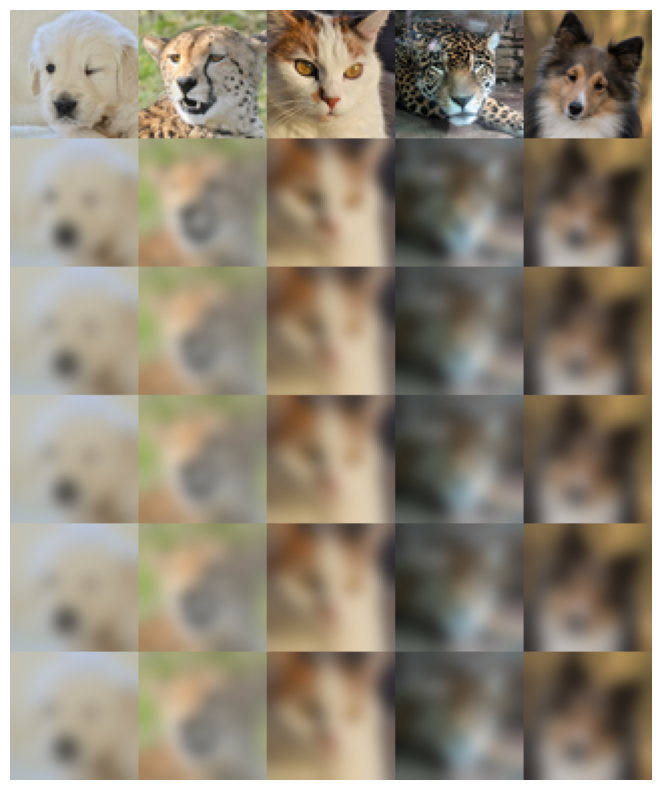

tensor([False, False, False,  True, False, False, False, False, False,  True,
         True, False,  True,  True,  True,  True, False, False,  True,  True,
        False, False, False,  True, False, False,  True, False,  True,  True,
        False,  True, False,  True, False, False, False,  True, False,  True,
         True,  True, False,  True, False, False, False, False, False, False,
         True, False,  True, False,  True, False,  True, False,  True, False,
        False,  True, False, False])
tensor([False, False, False,  True,  True,  True,  True,  True, False,  True,
         True,  True, False,  True,  True, False, False,  True, False, False,
        False, False,  True, False, False,  True, False,  True,  True,  True,
        False, False,  True, False, False,  True,  True, False,  True,  True,
         True, False, False, False,  True, False,  True, False,  True,  True,
         True,  True, False, False, False, False, False, False, False,  True,
         True,  True, False

In [29]:
# Test Bansal Blackblurr Equivalence
kwargs['device'] = 'cpu'

data = next(iter(trainloader))
num_samples = 5
t = torch.full((num_samples,), 87, dtype=torch.long).to(kwargs['device'])
t2 = torch.full((num_samples,), 76, dtype=torch.long).to(kwargs['device'])
t_diff = t - t2
tm1_diff = (t-1) - t2

x0 = data[0][0:num_samples].to(kwargs['device'])

dct = DCTBlurSampling(sampler.degradation.dct_blur.blur_sigmas, kwargs['image_size'], kwargs['device'])

# Calculcate reblurring for DCT
stdt = sampler.degradation.blur.dct_sigmas[t[0].item()]
stdtm1 = sampler.degradation.blur.dct_sigmas[t[0].item()-1]
stdt2 = sampler.degradation.blur.dct_sigmas[t2[0].item()] if t2[0].item() != -1 else 0

# Manually calculating DCT timesteps
t_dct = torch.full((num_samples,), stdt**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
tm1_dct = torch.full((num_samples,), stdtm1**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])
t2_dct = torch.full((num_samples,), stdt2**2/2, dtype=torch.float32)[:, None, None, None].to(kwargs['device'])

# Calculate DCT differences to get to t / t-1 from t2
t_diff_dct = t_dct - t2_dct
tm1_diff_dct = tm1_dct - t2_dct

# Actual reblurring
xt = dct(x0, t)
xtm1 = dct(x0, t-1)
xt2 = dct(x0, t2)

xt_hat = dct(xt2, t_diff, t=t_diff_dct)
xtm1_hat = dct(xt2, tm1_diff, t=tm1_diff_dct)


# Plot
plt.figure(figsize=(10, 10))
samples = torch.cat((x0, xt2, xtm1, xtm1_hat, xt, xt_hat), dim=0)
grid = make_grid(samples, nrow=5, padding=0)
grid = torch.clamp(grid, 0, 1)
plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()


print(xt_hat[0,0,0] == xt[0,0,0])
print(xtm1_hat[0,0,0] == xtm1[0,0,0])

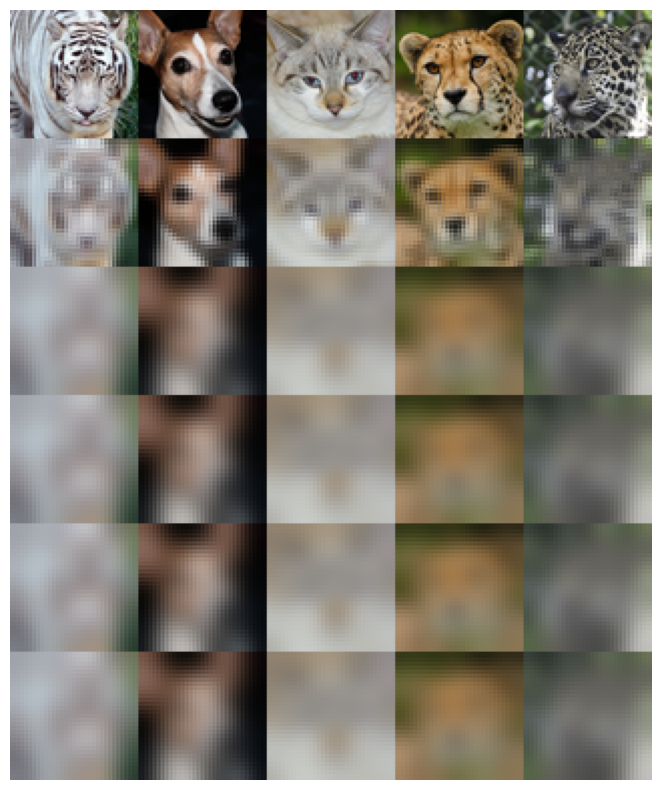

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False,

In [43]:
# Plot
plt.figure(figsize=(10, 10))
samples = torch.cat((x0, xt2, xtm1, xtm1_hat, xt, xt_hat), dim=0)
grid = make_grid(samples, nrow=5, padding=0)
grid = torch.clamp(grid, 0, 1)
plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()

print(xt_hat == xt)

In [38]:
d = torch.tensor(-1)
d

tensor(-1)

In [2]:
import torch

t = torch.randint(0, 200, (3,))
t2 = torch.clamp((t // 10) * 10 - 10, min=-1)




In [5]:
print(t, t2) 

tensor([177, 108, 175]) tensor([160,  90, 160])


In [10]:
t = torch.randint(0, 200, (70,))
t2 = []
for t_ in t: 
    x = (t_ // 10) + 1 # + 1 to be able to go to x0 from t
    diff = torch.randint(1, x + 1, (1,)).item() # +1 for indexing of torch.randint
    t2_ = t_ -  diff * 10
    t2.append(t2_)
t2 = torch.clamp(torch.tensor(t2), min=-1)

print("t:", t)
print("t2:", t2)


t: tensor([138,  99,  62,  42,  60,  61,  54, 153,  99, 136, 101,  14,  50,  77,
        179, 100, 199,  19, 109, 149,  75, 142,  11,  45, 185,  54, 193, 151,
        179, 101, 128,   4,  43, 124, 175, 195,  47,  74, 143, 120, 155, 107,
          5, 184,  81,  17,  51,  86, 147, 186, 193,  19, 165,  88,  77,  40,
        104, 130,   3,  40, 154, 159, 138,  19,  82,   6,  63,  28, 158,  14])
t2: tensor([ 98,  79,  12,  32,  30,  41,  24, 123,  89,  66,  51,  -1,  -1,  37,
         49,  30, 139,   9,  89,  49,  25,   2,   1,  15,   5,  -1,  -1,  61,
         29,  31,  88,  -1,  -1,  54, 165, 125,   7,  44,  73,  30,  95,  17,
         -1,  -1,  61,   7,   1,  66, 137,  -1, 183,   9,  85,  78,  47,  10,
         14,  50,  -1,   0,  84,  39,  38,  -1,  12,  -1,  53,   8,  28,   4])


In [11]:
t_diff = t - t2
print(t_diff)

tensor([ 40,  20,  50,  10,  30,  20,  30,  30,  10,  70,  50,  15,  51,  40,
        130,  70,  60,  10,  20, 100,  50, 140,  10,  30, 180,  55, 194,  90,
        150,  70,  40,   5,  44,  70,  10,  70,  40,  30,  70,  90,  60,  90,
          6, 185,  20,  10,  50,  20,  10, 187,  10,  10,  80,  10,  30,  30,
         90,  80,   4,  40,  70, 120, 100,  20,  70,   7,  10,  20, 130,  10])


In [212]:

# Create the slider widget
step_size_slider = widgets.IntSlider(value=20, min=5, max=kwargs['timesteps'], step=5, description='step size')
steps = kwargs['timesteps'] // step_size_slider.value
mean_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='mean manipulation')
std_slider = widgets.FloatSlider(value=0, min=-10, max=10, step=0.001, description='std manipulation')
dim_slider = widgets.IntSlider(value=0, min=0, max=kwargs['latent_dim']-1, step=1, description='dimension to manipulate')
t_slider = widgets.IntSlider(value=0, min=0, max=steps, step=1, description='t to manipulate')
bansal_toggle = widgets.Checkbox(value=False, description='Bansal Sampling')

# Create the interactive window
interactive_window = widgets.interactive(latent_interactor_dct.full_loop, 
                                         step_size=step_size_slider, 
                                         mean=mean_slider, 
                                         std=std_slider, 
                                         dim=dim_slider, 
                                         t_int=t_slider,
                                         bansal_sampling=bansal_toggle)

# Display the interactive window
display(interactive_window)


interactive(children=(IntSlider(value=20, description='step size', max=200, min=5, step=5), FloatSlider(value=…

In [48]:
# Custom DCT Blur Module for Bansal Style Sampling

import dct_blur as torch_dct


class DCTBlur(nn.Module):

    def __init__(self, blur_sigmas, image_size, device):
        super(DCTBlur, self).__init__()
        self.blur_sigmas = blur_sigmas.clone().detach().to(device)
        freqs = np.pi*torch.linspace(0, image_size-1,
                                    image_size).to(device)/image_size
        self.frequencies_squared = freqs[:, None]**2 + freqs[None, :]**2

    def forward(self, x, fwd_steps, t = None):
        if len(x.shape) == 4:
            sigmas = self.blur_sigmas[fwd_steps][:, None, None, None]
        elif len(x.shape) == 3:
            sigmas = self.blur_sigmas[fwd_steps][:, None, None]
            print(sigmas)
        
        if t is None:
            t = sigmas**2/2
        else:
            assert t.shape == sigmas.shape, f"t must be of equal shape as sigmas, got {t.shape} as shape instead of {sigmas.shape}."
            pass
            
        dct_coefs = torch_dct.dct_2d(x, norm='ortho')
        dct_coefs = dct_coefs * torch.exp(- self.frequencies_squared * t)
        dct_blurred = torch_dct.idct_2d(dct_coefs, norm='ortho')
        dct_blurred[fwd_steps == -1] = x[fwd_steps == -1] # Keep the original image for t=-1 (needed for Bansal style sampling)
        return dct_blurred
    

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0

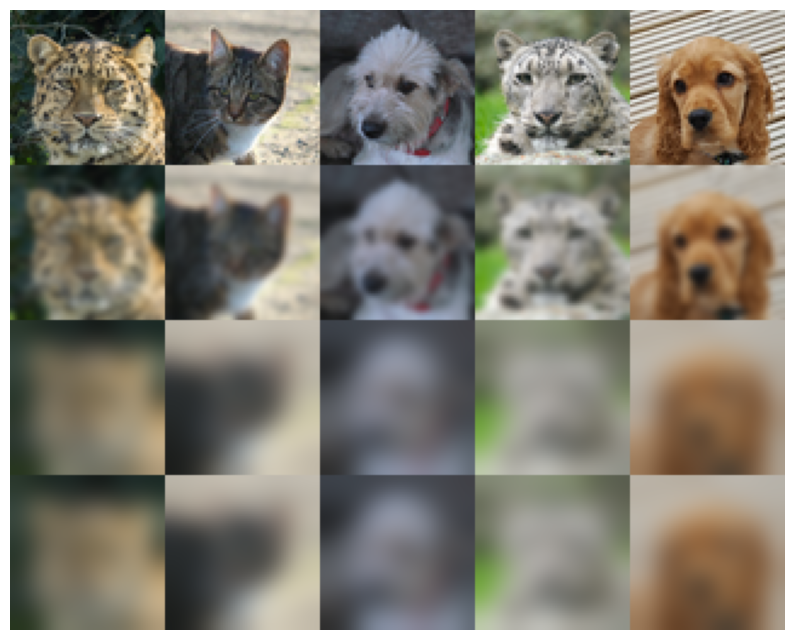

In [60]:
# TRIAL with DCT Difference

kwargs['device'] = 'cpu'

data = next(iter(trainloader))
num_samples = 5
x0 = data[0][0:num_samples].to(kwargs['device'])

t = torch.full((5,), 100, dtype=torch.long).to(kwargs['device'])
t2 = torch.full((5,), 50, dtype=torch.long).to(kwargs['device'])
t_diff = t - t2

dct_sigmas = sampler.degradation.blur.dct_sigmas    

std1 = dct_sigmas[t[0].item()]
std2 = dct_sigmas[t2[0].item()]

t_dct = torch.full((5,), std1**2/2, dtype=torch.long)[:, None, None, None].to(kwargs['device']) 
t2_dct = torch.full((5,), std2**2/2, dtype=torch.long)[:, None, None, None].to(kwargs['device']) 
t_diff_dct = t_dct - t2_dct

dct = DCTBlurSampling(dct_sigmas, kwargs['image_size'], kwargs['device'])
dct_blurred_t = dct(x0, t)
dct_blurred_t = dct(x0, t, t=t_dct)
dct_blurred_t2 = dct(x0, t2, t=t2_dct)
dct_blurred_t_hat = dct(dct_blurred_t2, t_diff, t=t_diff_dct)

plt.figure(figsize=(10, 10))
samples = torch.cat((x0, dct_blurred_t2, dct_blurred_t_hat, dct_blurred_t), dim=0)
grid = make_grid(samples, nrow=5, padding=0)
grid = torch.clamp(grid, 0, 1)
plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.show()



In [61]:
print(dct_blurred_t_hat[0,0,0] == dct_blurred_t[0,0,0])

print(dct_blurred_t_hat[0,0,0])
print(dct_blurred_t[0,0,0])

tensor([False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False,  True])
tensor([0.1660, 0.1653, 0.1640, 0.1620, 0.1596, 0.1566, 0.1534, 0.1500, 0.1464,
        0.1428, 0.1393, 0.1359, 0.1328, 0.1298, 0.1272, 0.1249, 0.1228, 0.1211,
        0.1195, 0.1182, 0.1169, 0.1157, 0.1143, 0.1128, 0.1111, 0.1092, 0.1071,
        0.1047, 0.1023, 0.0998, 0.0974, 0.0952, 0.0932, 0.0915, 0.0902, 0.0894,
        0.0891, 0.0892, 0.0898, 0.0910, 0.0925, 0.0946, 0.0969, 0.0996, 0.1024,
        0.1052, 0.1079, 0.1104, 0.1125, 0.1141, 0.1153, 0.1159, 0.1159, 0.1156,
        0.1148,

In [ ]:
blurred_t[0,0,0] == blurred_t_stepwise[0,0,0]

print(blurred_t[0,0,0])
print(blurred_t_stepwise[0,0,0])

In [21]:
class ModelInteract():

    def __init__(self, model, timesteps):
        self.model = model
        self.t = torch.full((kwargs['n_samples'],), timesteps, dtype=torch.long).to(kwargs['device'])
        self.xt = torch.zeros((kwargs['n_samples'], channels, kwargs['image_size'], kwargs['image_size']), device=kwargs['device']) 
        self.prior = torch.randn(kwargs['n_samples'], kwargs['latent_dim']).to(kwargs['device'])

    @torch.no_grad()
    def predict(self, t_diff, plot = True):
        t = self.t[0].item()
        #print(t)
        t2 = int(t - t_diff)
    
        if t2 < 0: 
            t2 = - 1

        self.t2 = torch.full((kwargs['n_samples'],), t2, dtype=torch.long).to(kwargs['device'])
        self.pred = self.model(self.xt, self.t, cond=None, prior=self.prior, t2=self.t2)
        self.t_diff = t_diff
        
        if plot:
            self.plot(self.xt + self.pred)
    
    def manipulate_prior(self, dim, mean = 0, std = 1):
        man_prior = self.prior[:,dim] * std + mean
        self.prior[:,dim] = self.prior[:,dim] * std + mean


    def update_xt(self, b, plot = True):
        self.xt = (self.xt + self.pred)
        self.t = self.t2
        print("New timesteps set to", self.t[0].item())
        
        if plot:
            self.plot(self.xt)
        
    def update_and_step(self, b, plot = True):
        self.predict(self.t_diff, plot = True)
        self.update_xt(b, plot = False)
    

    def plot(self, input):
        grid = make_grid(input[:10], nrow=10, padding=0)
        # Map grid to 0-1
        grid = (grid - torch.min(grid)) / (torch.max(grid) - torch.min(grid))
        grid = torch.clamp(grid, 0, 1)
        #print(torch.min(grid).item(), torch.max(grid).item())
        plt.imshow(grid.cpu().detach().numpy().transpose(1, 2, 0), vmin = torch.min(grid).item(), vmax = torch.max(grid).item())
        plt.axis('off')
        plt.show()


interactor = ModelInteract(trainer.model, kwargs['timesteps'])


In [ ]:
# NEXT TASK: Visualize Process GIF for Bansal Sampling and Regular Sampling

# NEXT TASK: Implement more efficient variable timestep sampling - not every step, but every 10th step (RETHING CURRENT CODE - THINK MORE IN STEPS OF 10)

# NEXT TASK: Fix sampling in diffusion utils

interactive(children=(IntSlider(value=1, description='t difference', max=200, min=-1), Checkbox(value=True, de…

Button(description='Update xt', style=ButtonStyle())

Button(description='Update and predict next xt', style=ButtonStyle())

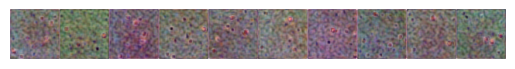

New timesteps set to 186


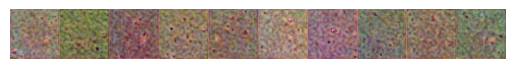

New timesteps set to 172


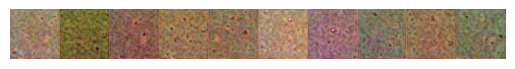

New timesteps set to 158


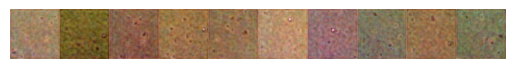

New timesteps set to 144


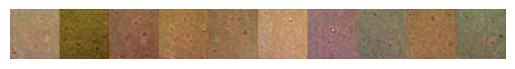

New timesteps set to 130


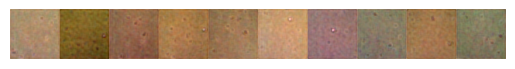

New timesteps set to 116


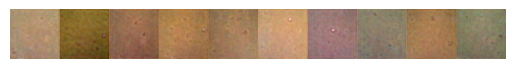

New timesteps set to 102


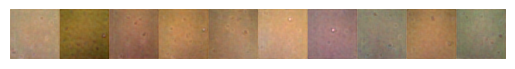

New timesteps set to 88


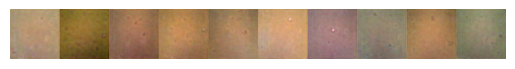

New timesteps set to 74


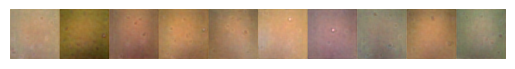

New timesteps set to 60


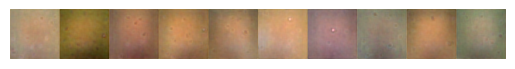

New timesteps set to 46


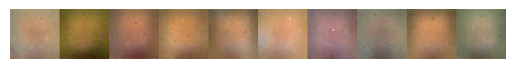

New timesteps set to 32


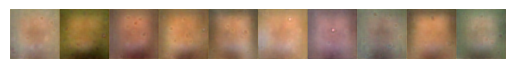

New timesteps set to 18


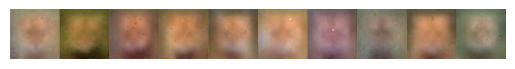

New timesteps set to 4


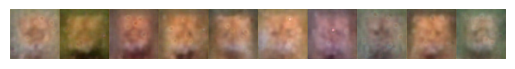

New timesteps set to -1


In [25]:

import ipywidgets as widgets
from IPython.display import display

#samples = torch.cat((samples, xt[0:num_samples]), dim=0)

# Create the button widget
update_button = widgets.Button(description='Update xt')
update_button.on_click(interactor.update_xt)

update_predict_button = widgets.Button(description='Update and predict next xt')
update_predict_button.on_click(interactor.update_and_step)

# Create the slider widget
tdiff_slider = widgets.IntSlider(value=1, min=-1, max=kwargs['timesteps'], step=1, description='t difference')

# Create the interactive window
interactive_window = widgets.interactive(interactor.predict, t_diff=tdiff_slider)

# Display the interactive window
display(interactive_window, update_button, update_predict_button)
